In [2]:
# !pip install pillow
# !pip install opencv-python
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow==2.10
# !pip install scikit-learn

**Ini merupakan project computer vision untuk deteksi kantuk pengemudi kendaraan yang menggunakan algoritma Convolutional Neural Network (CNN) dengan pengimplementasian Transfer Learning EfficientNetV2S menggunakan library tensorflow**

Dataset: https://www.kaggle.com/datasets/hazemfahmy/openned-closed-eyes/data

by Hazem Fahmy

**Tentang Dataset**

Selamat datang di Dataset Deteksi Kantuk UnityEyes! Dataset komprehensif ini dirancang untuk membantu para peneliti dan pengembang dalam tugas penting deteksi kantuk, yang secara khusus berfokus pada identifikasi pengemudi yang mengantuk berdasarkan perilaku mata. Dataset ini dikumpulkan menggunakan UnityEyes, sebuah simulator sintetis mata yang canggih, untuk memastikan data berkualitas tinggi. Data tersebut diberi label menggunakan ambang batas keterbukaan = 20 (referensi: https://github.com/SNTSVV/HUDD-Toolset)

Dataset Deteksi Mengantuk terdiri dari beragam koleksi rekaman gerakan mata dari subjek dengan demografi yang berbeda-beda, yang diambil dalam skenario mengemudi yang terkendali. Data tersebut mencakup urutan gambar mata, yang diberi label secara cermat untuk menunjukkan apakah mata terbuka atau tertutup, yang berfungsi sebagai kebenaran dasar untuk mendeteksi pengemudi yang mengantuk.

## **Import Library**

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import  Image
import string

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(tf.__version__)

2.12.0


In [4]:
import warnings
# Abaikan semua warning
warnings.filterwarnings('ignore')

Beberapa fungsi library yang digunakan:
- **os**: Untuk mengoperasikan sistem operasi.
- **cv2**: OpenCV untuk tugas-tugas computer vision.
- **PIL**: Library pencitraan Python untuk tugas-tugas pemrosesan gambar.
- **numpy**: Untuk komputasi numerik dan matriks.
- **matplotlib.pyplot**: Untuk visualisasi plot.
- **seaborn**: Untuk visualisasi plot.
- **sklearn**: Untuk preprocessing data dan evaluasi akurasi
- **tensorflow**: Untuk membangun dan melatih model pembelajaran mesin.

## **Load Data from Directory**

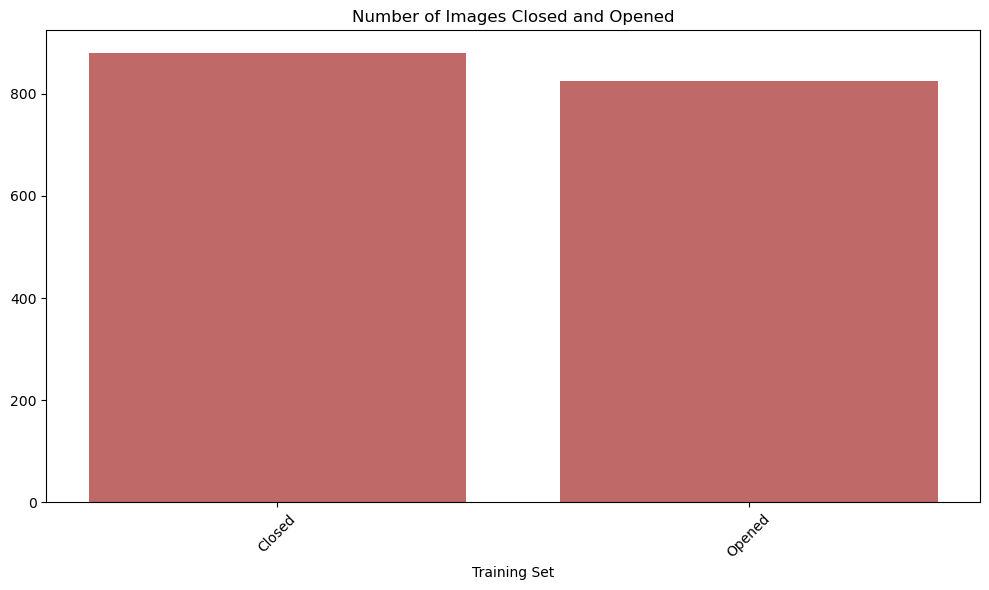

In [5]:
# directory yang mengandung Image
root_dir = './drownisess/TrainingSet/TrainingSet'

# Iterasi melalui setiap folder di direktori root
folder_image_count = {}

for data in os.listdir(root_dir):
    path_folder = os.path.join(root_dir, data)
    if os.path.isdir(path_folder):
        # Menghitung jumlah file gambar di dalam folder
        num_images = len([name for name in os.listdir(path_folder) if os.path.isfile(os.path.join(path_folder, name)) and name.lower().endswith(('.png', '.jpg', '.jpeg'))])
        folder_image_count[data] = num_images

# Extract nama folder dan jumlah gambar yang sesuai
folders = list(folder_image_count.keys())
img_counts = list(folder_image_count.values())

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(folders)), img_counts, color = 'brown', align='center', alpha=0.7)
plt.xticks(range(len(folders)), folders, rotation=45)
plt.xlabel('Training Set')
plt.title('Number of Images Closed and Opened')
plt.tight_layout()
plt.show()

Setelah melakukan exttact data dari direktori path yang telah ditentukan, di dapatkan data Training Set yang terdiri dari 2 data mata Terbuka dengan 824 gambar dan mata Mengantuk dengan 880 gambar. Pastikan folder dataset berada ditempat yang sama seperti folder .py atau jupyter anda.

Contoh direktori yang benar:

**Project**

----- **drownisess**
 
----- **drownisess-detection.ipynb**

## **Preprocessing Data**

Setelah dilakukan extract data, akan dilakukan transform data. Dataset akan dikelompokan berdasarkan label masing-masing lalu dilakukan resize image untuk mengcompress gambar mnejadi ukuran 150x150 dengan 3 channel warna karena merupakan gambar RGB.

In [6]:
categories = ['Opened', 'Closed'] # Folder yang akan dimuat
image_size = (150, 150) # Untuk setting ukuran gambar

# Inisialisasi list untuk menyimpan data dan label
X = []
Y = []

# Memuat gambar dan label dari setiap folder
for label, category in enumerate(categories):
    folder_path = os.path.join(root_dir, category)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize(image_size)  # Mengubah ukuran gambar
            img_array = np.array(img)     # Mengonversi gambar menjadi array numpy
            X.append(img_array)
            Y.append(label)

# Mengonversi list X dan Y menjadi array numpy
X = np.array(X)
Y = np.array(Y)

Label mata terbuka **“Opened”: 0** dan Label mata mengantuk **“Closed”: 1**

In [7]:
print(f'Total gambar: {len(X)}')
print(f'Total label: {len(Y)}')
print('kode label:', np.unique(Y))

Total gambar: 1704
Total label: 1704
kode label: [0 1]


In [8]:
X[0]

array([[[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       ...,

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]]], dtype=uint8)

Melakukan load data yang telah di extract dan di transform untuk melihat 5 sampel masing-masing setiap label

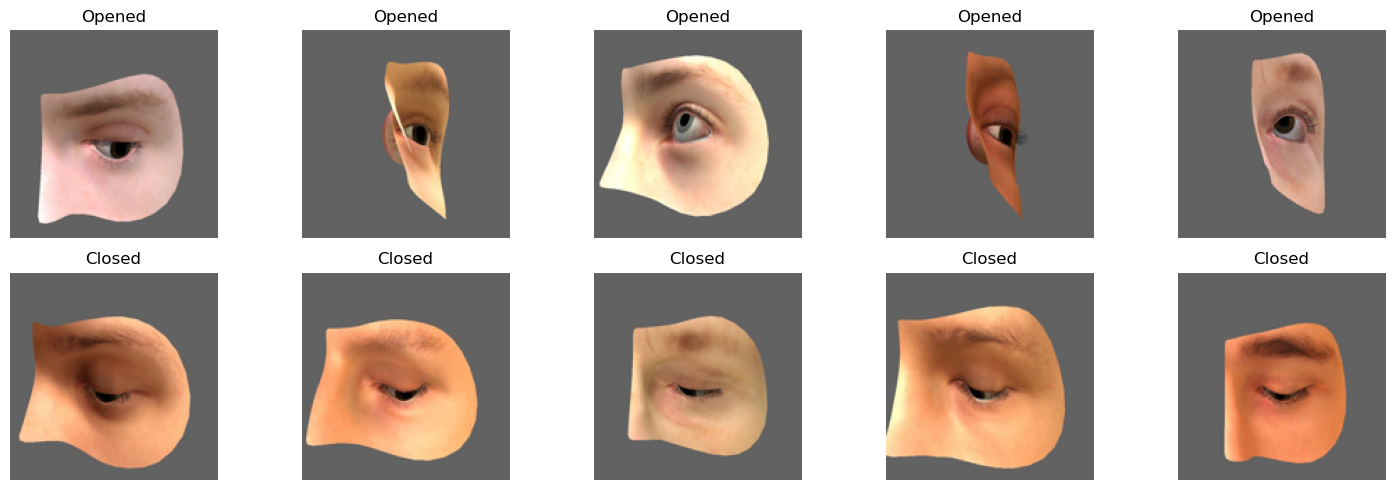

In [9]:
# Memisahkan gambar berdasarkan label
X_opened = X[Y == 0]
X_closed = X[Y == 1]

# Mengambil 5 sampel acak dari masing-masing kategori
opened_samples = np.random.choice(len(X_opened), 5, replace=False)
closed_samples = np.random.choice(len(X_closed), 5, replace=False)

X_samples = np.concatenate((X_opened[opened_samples], X_closed[closed_samples]))
Y_samples = np.concatenate((np.zeros(5), np.ones(5)))

# Menampilkan 10 sampel gambar
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_samples[i])
    plt.title('Opened' if Y_samples[i] == 0 else 'Closed')
    plt.axis('off')
plt.tight_layout()
plt.show()

Membagi data menjadi data training 90% dan data validation 10%

In [10]:
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.1, random_state=79)

In [11]:
print(x_train.shape)
print(y_train.shape)

(1533, 150, 150, 3)
(1533,)


terdapat 1533 gambar untuk data training

In [12]:
print(x_validation.shape)
print(y_validation.shape)

(171, 150, 150, 3)
(171,)


terdapat 171 gambar untuk data validation

In [13]:
# Mengonversi y_train dan y_validation menjadi kategorikal (one-hot encoded vectors.)
y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)

## **Model 1 CNN + EfficientNetV2S [Trainable 30 last layer - Regularization Yes - Batch Size 32]**

Model pertama adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning EfficientNetV2S dengan melakukan tarining 30 layer terakhir V2S, memakai regularization dan batch size = 32

In [14]:
# Define jumlah kelas
num_classes = 2

In [15]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Membuka beberapa layer terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Disable semua layer untuk dilatih kecuali 30 layer terakhir
    layer.trainable = False

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_v2s_1
x = base_model(inputs, training=True)  # training=True untuk memastikan fine-tuning
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(0.01)  # Menambahkan weight regularization
)(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_v2s_1
model_v2s_1 = Model(inputs, outputs)

# Compile model_v2s_1
model_v2s_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointV2S_1 = ModelCheckpoint(
    'best_model_v2s_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_v2s_1 dengan batch size 32
batch_size = 32
historyV2S_1 = model_v2s_1.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointV2S_1, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 5.1629 - accuracy: 0.8774
Epoch 1: val_accuracy improved from -inf to 0.91228, saving model to best_model_v2s_1.h5
48/48 [==============================] - 86s 1s/step - loss: 5.1629 - accuracy: 0.8774 - val_loss: 1.4016 - val_accuracy: 0.9123
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.9328
Epoch 2: val_accuracy improved from 0.91228 to 0.95906, saving model to best_model_v2s_1.h5
48/48 [==============================] - 64s 1s/step - loss: 0.6765 - accuracy: 0.9328 - val_loss: 0.3396 - val_accuracy: 0.9591
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9367
Epoch 3: val_accuracy did not improve from 0.95906
48/48 [==============================] - 65s 1s/step - loss: 0.2597 - accuracy: 0.9367 - val_loss: 0.2391 - val_accuracy: 0.9415
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9478
Epoch

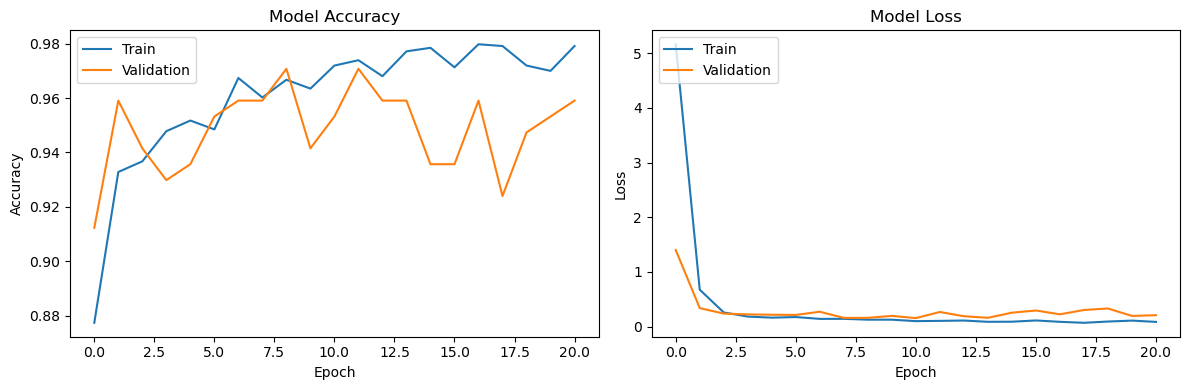

In [16]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S_1.history['accuracy'])
ax1.plot(historyV2S_1.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S_1.history['loss'])
ax2.plot(historyV2S_1.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_v2s_1.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_v2s_1.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_v2s_1 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + EfficientNetV2S 1:')
print(class_report_v2s_1)

6/6 [==============================] - 8s 1s/step - loss: 0.1962 - accuracy: 0.9357
validation accuracy: 93.567%
validation loss: 0.1962
6/6 [==============================] - 9s 797ms/step
Classification Report Model CNN + EfficientNetV2S 1:
              precision    recall  f1-score   support

      Opened       0.98      0.94      0.96        87
      Closed       0.94      0.98      0.96        84

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



In [18]:
# # Load model terbaik dari checkpoint
# best_model_v2s_1 = tf.keras.models.load_model('best_model_v2s_1.h5')

# # Evaluasi akurasi dan loss pada set validation
# loss, accuracy = best_model_v2s_1.evaluate(x_validation, y_validation)
# print(f'Validation Accuracy: {accuracy * 100:.3f}%')
# print(f'Validation Loss: {loss:.4f}')

# # Generate classification report
# y_pred = best_model_v2s_1.predict(x_validation)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_validation, axis=1)

# # Membuat classification_report
# class_report_best_v2s_1 = classification_report(y_true, y_pred_classes, target_names=categories)
# print('Classification Report Model CNN + EfficientNetV2S 1:')
# print(class_report_best_v2s_1)

Confusion Matrix:
[[82  5]
 [ 2 82]]


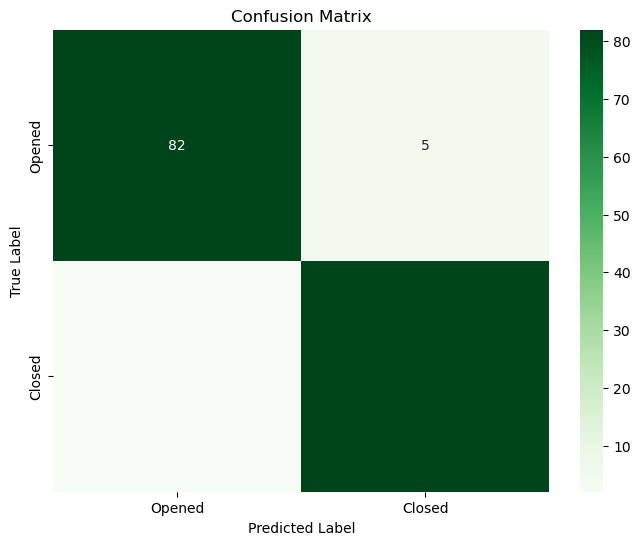

In [19]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model EfficientNetV2S 1**

1/1 [==============================] - 0s 63ms/step


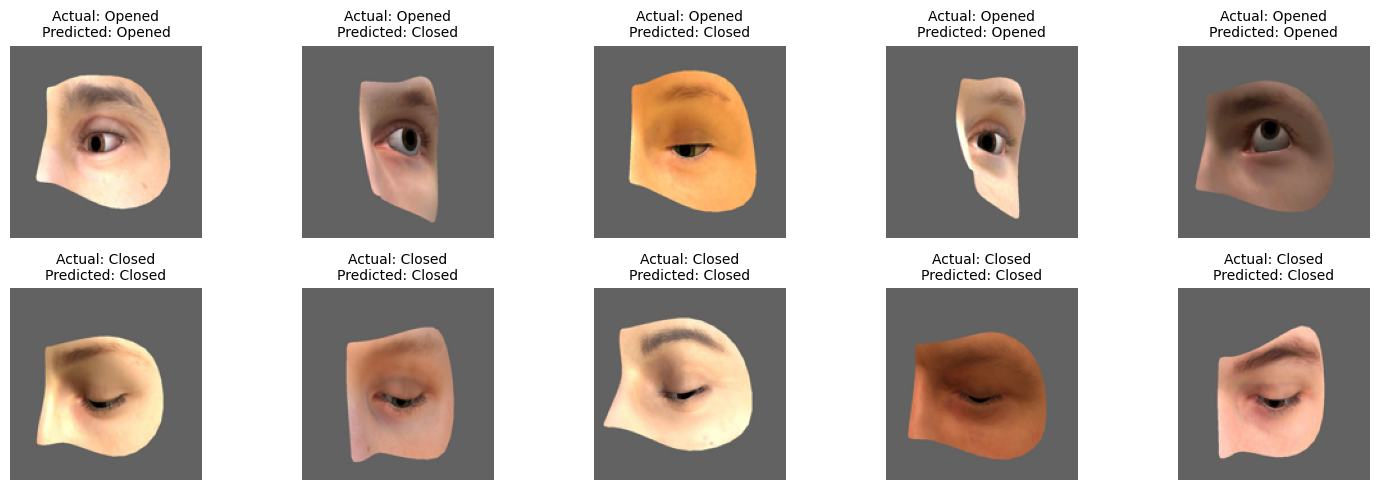

In [20]:
# Load model_predict_1 .h5
model_predict_1 = tf.keras.models.load_model('best_model_v2s_1.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_1.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 2 CNN + EfficientNetV2S [No Trainable 30 last layer - Regularization Yes - Batch Size 32]**

Model kedua adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning EfficientNetV2S tanpa melakukan tarining 30 layer terakhir V2S, memakai regularization dan batch size = 32

In [21]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_v2s_2
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_v2s_2
model_v2s_2 = Model(inputs, outputs)

# Compile model_v2s_2
model_v2s_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointV2S_2 = ModelCheckpoint(
    'best_model_v2s_2.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_v2s_2 dengan batch size 32
batch_size = 32
historyV2S_2 = model_v2s_2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointV2S_2, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 5.4913 - accuracy: 0.8545
Epoch 1: val_accuracy improved from -inf to 0.90643, saving model to best_model_v2s_2.h5
48/48 [==============================] - 66s 1s/step - loss: 5.4913 - accuracy: 0.8545 - val_loss: 1.7843 - val_accuracy: 0.9064
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 1.0402 - accuracy: 0.9067
Epoch 2: val_accuracy did not improve from 0.90643
48/48 [==============================] - 50s 1s/step - loss: 1.0402 - accuracy: 0.9067 - val_loss: 0.6484 - val_accuracy: 0.8772
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.9185
Epoch 3: val_accuracy improved from 0.90643 to 0.92982, saving model to best_model_v2s_2.h5
48/48 [==============================] - 50s 1s/step - loss: 0.4884 - accuracy: 0.9185 - val_loss: 0.3717 - val_accuracy: 0.9298
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.3501 - accuracy: 0.9204
Epoch

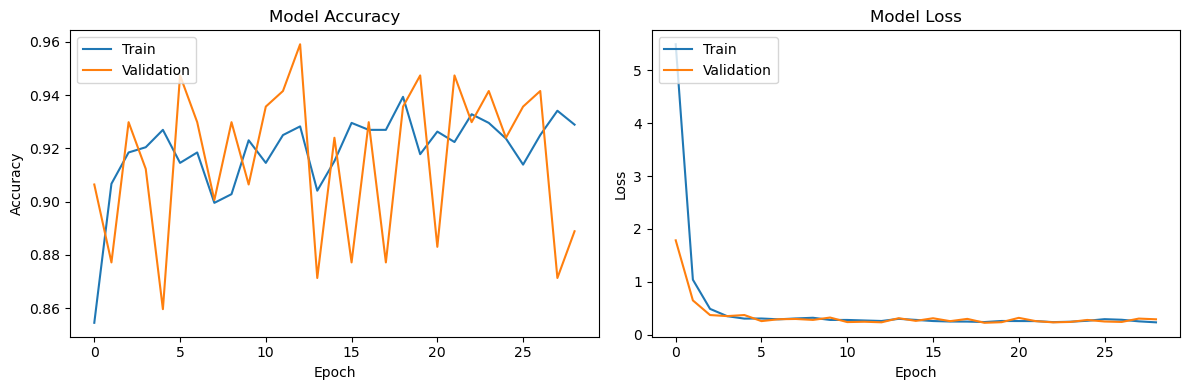

In [22]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S_2.history['accuracy'])
ax1.plot(historyV2S_2.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S_2.history['loss'])
ax2.plot(historyV2S_2.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_v2s_2.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_v2s_2.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_v2s_2 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + EfficientNetV2S 2:')
print(class_report_v2s_2)

6/6 [==============================] - 9s 2s/step - loss: 0.2250 - accuracy: 0.9357
validation accuracy: 93.567%
validation loss: 0.2250
6/6 [==============================] - 11s 795ms/step
Classification Report Model CNN + EfficientNetV2S 2:
              precision    recall  f1-score   support

      Opened       0.99      0.89      0.93        87
      Closed       0.89      0.99      0.94        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



In [24]:
# # Load model terbaik dari checkpoint
# best_model_v2s_2 = tf.keras.models.load_model('best_model_v2s_2.h5')

# # Evaluasi akurasi dan loss pada set validation
# loss, accuracy = best_model_v2s_2.evaluate(x_validation, y_validation)
# print(f'Validation Accuracy: {accuracy * 100:.3f}%')
# print(f'Validation Loss: {loss:.4f}')

# # Generate classification report
# y_pred = best_model_v2s_2.predict(x_validation)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_validation, axis=1)

# # Membuat classification_report
# class_report_best_v2s_2 = classification_report(y_true, y_pred_classes, target_names=categories)
# print('Classification Report Model CNN + EfficientNetV2S 2:')
# print(class_report_best_v2s_2)

Confusion Matrix:
[[77 10]
 [ 1 83]]


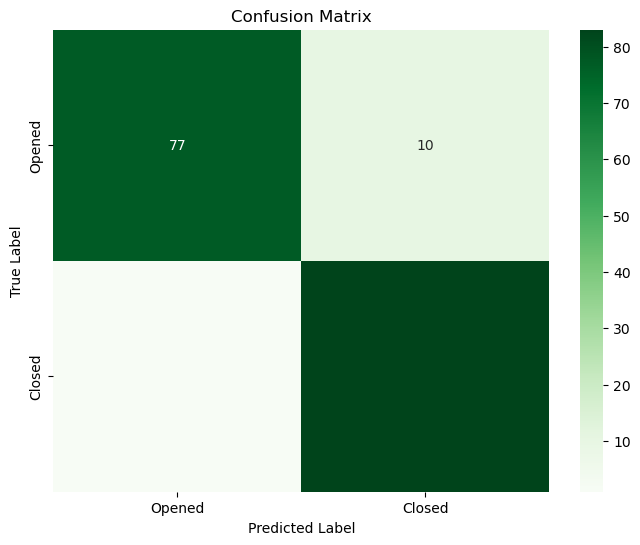

In [25]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model EfficientNetV2S 2**

1/1 [==============================] - 0s 64ms/step


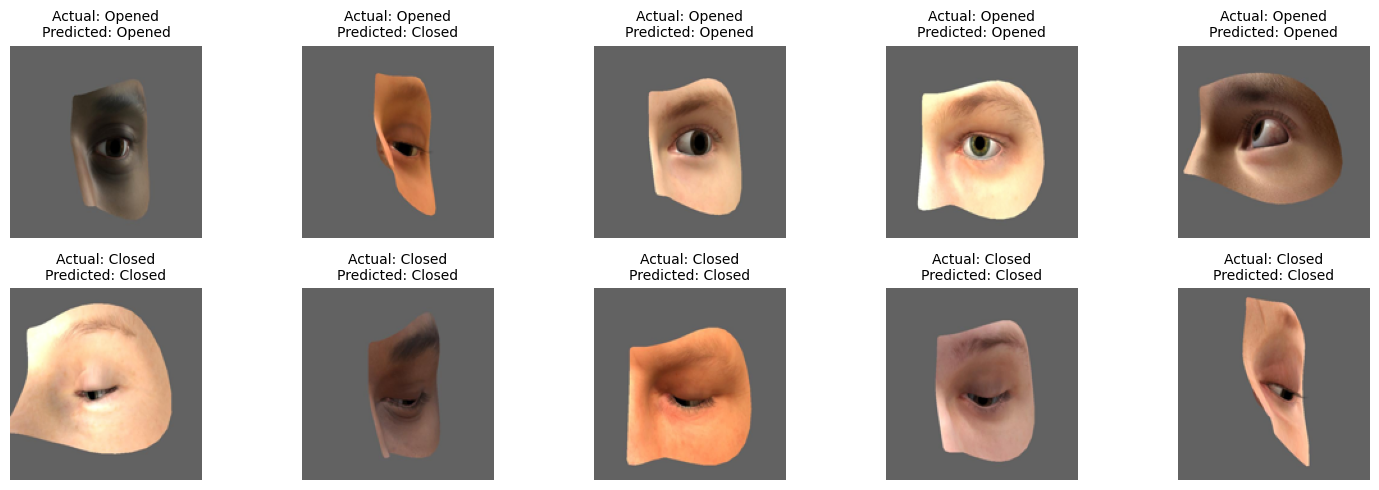

In [26]:
# Load model_predict_2 .h5
model_predict_2 = tf.keras.models.load_model('best_model_v2s_2.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_2.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 3 CNN + EfficientNetV2S [Trainable 30 last layer - Regularization No - Batch Size 32]**

Model ketiga adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning EfficientNetV2S dengan melakukan tarining 30 layer terakhir V2S, tanpa regularization dan batch size = 32

In [27]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Membuka beberapa layer terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Disable semua layer untuk dilatih kecuali 30 layer terakhir
    layer.trainable = False

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_v2s_3
x = base_model(inputs, training=True)  # training=True untuk memastikan fine-tuning
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_v2s_3
model_v2s_3 = Model(inputs, outputs)

# Compile model_v2s_3
model_v2s_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointV2S_3 = ModelCheckpoint(
    'best_model_v2s_3.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_v2s_3 dengan batch size 32
batch_size = 32
historyV2S_3 = model_v2s_3.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointV2S_3, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8702
Epoch 1: val_accuracy improved from -inf to 0.91228, saving model to best_model_v2s_3.h5
48/48 [==============================] - 90s 2s/step - loss: 0.3342 - accuracy: 0.8702 - val_loss: 0.2150 - val_accuracy: 0.9123
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9217
Epoch 2: val_accuracy improved from 0.91228 to 0.94737, saving model to best_model_v2s_3.h5
48/48 [==============================] - 71s 1s/step - loss: 0.1877 - accuracy: 0.9217 - val_loss: 0.1714 - val_accuracy: 0.9474
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.9393
Epoch 3: val_accuracy improved from 0.94737 to 0.97076, saving model to best_model_v2s_3.h5
48/48 [==============================] - 77s 2s/step - loss: 0.1517 - accuracy: 0.9393 - val_loss: 0.1131 - val_accuracy: 0.9708
Epoch 4/30
48/48 [==============================] - ETA: 0

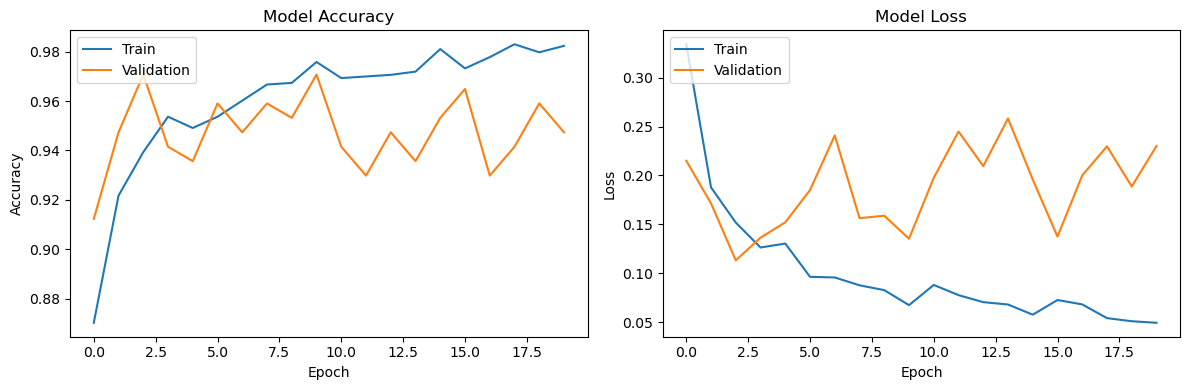

In [28]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S_3.history['accuracy'])
ax1.plot(historyV2S_3.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S_3.history['loss'])
ax2.plot(historyV2S_3.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_v2s_3.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_v2s_3.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_v2s_3 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + EfficientNetV2S 3:')
print(class_report_v2s_3)

6/6 [==============================] - 8s 1s/step - loss: 0.1653 - accuracy: 0.9649
validation accuracy: 96.491%
validation loss: 0.1653
6/6 [==============================] - 15s 1s/step
Classification Report Model CNN + EfficientNetV2S 3:
              precision    recall  f1-score   support

      Opened       0.99      0.95      0.97        87
      Closed       0.95      0.99      0.97        84

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



Confusion Matrix:
[[83  4]
 [ 1 83]]


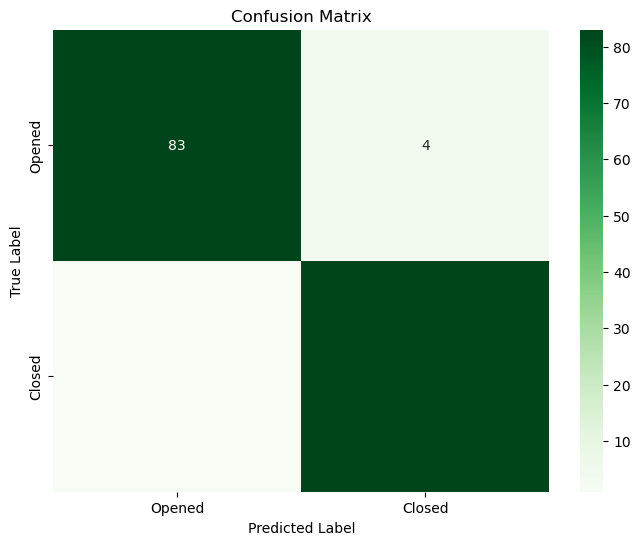

In [30]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model EfficientNetV2S 3**

1/1 [==============================] - 0s 93ms/step


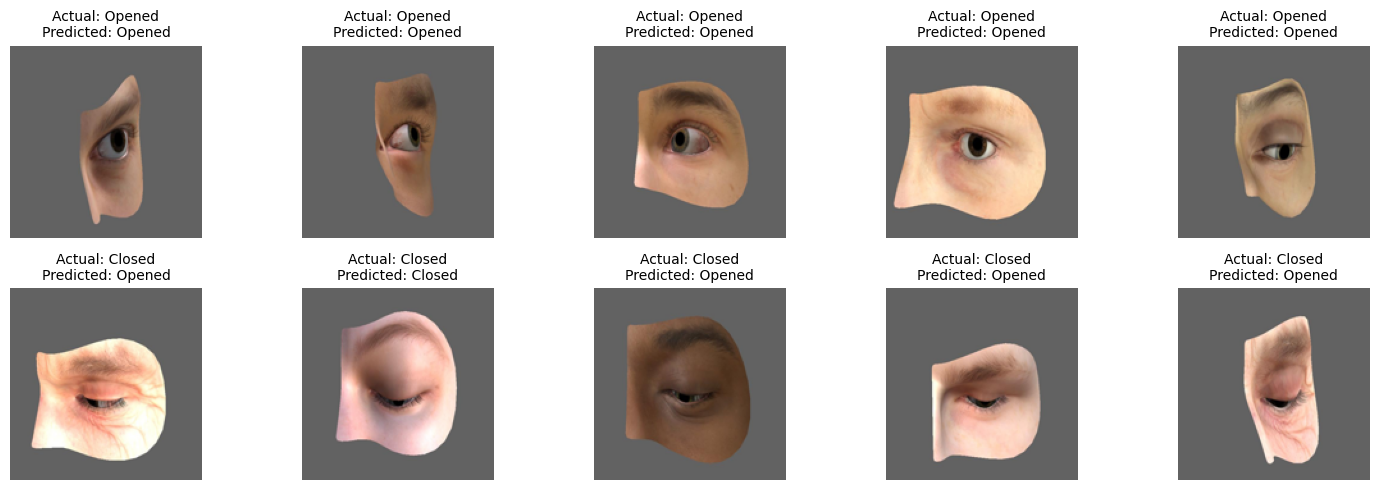

In [31]:
# Load model_predict_3 .h5
model_predict_3 = tf.keras.models.load_model('best_model_v2s_3.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_3.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 4 CNN + EfficientNetV2S [No Trainable 30 last layer - Regularization No - Batch Size 32]**

Model keempat adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning EfficientNetV2S tanpa melakukan tarining 30 layer terakhir V2S, tanpa regularization dan batch size = 32

In [32]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_v2s_4
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_v2s_4
model_v2s_4 = Model(inputs, outputs)

# Compile model_v2s_4
model_v2s_4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointV2S_4 = ModelCheckpoint(
    'best_model_v2s_4.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_v2s_4 dengan batch size 32
batch_size = 32
historyV2S_4 = model_v2s_4.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointV2S_4, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8630
Epoch 1: val_accuracy improved from -inf to 0.94737, saving model to best_model_v2s_4.h5
48/48 [==============================] - 95s 2s/step - loss: 0.2921 - accuracy: 0.8630 - val_loss: 0.1951 - val_accuracy: 0.9474
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9295
Epoch 2: val_accuracy did not improve from 0.94737
48/48 [==============================] - 76s 2s/step - loss: 0.1800 - accuracy: 0.9295 - val_loss: 0.1902 - val_accuracy: 0.9240
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9406
Epoch 3: val_accuracy did not improve from 0.94737
48/48 [==============================] - 86s 2s/step - loss: 0.1560 - accuracy: 0.9406 - val_loss: 0.1690 - val_accuracy: 0.9298
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9550
Epoch 4: val_accuracy did not improve from 0.9

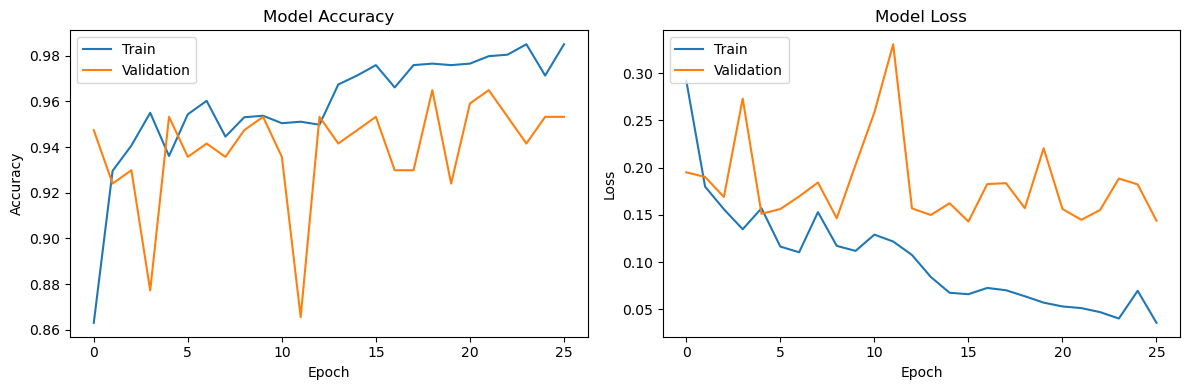

In [33]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S_4.history['accuracy'])
ax1.plot(historyV2S_4.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S_4.history['loss'])
ax2.plot(historyV2S_4.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_v2s_4.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_v2s_4.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_v2s_4 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + EfficientNetV2S 4:')
print(class_report_v2s_4)

6/6 [==============================] - 9s 1s/step - loss: 0.1430 - accuracy: 0.9532
validation accuracy: 95.322%
validation loss: 0.1430
6/6 [==============================] - 11s 880ms/step
Classification Report Model CNN + EfficientNetV2S 4:
              precision    recall  f1-score   support

      Opened       0.95      0.95      0.95        87
      Closed       0.95      0.95      0.95        84

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



Confusion Matrix:
[[83  4]
 [ 4 80]]


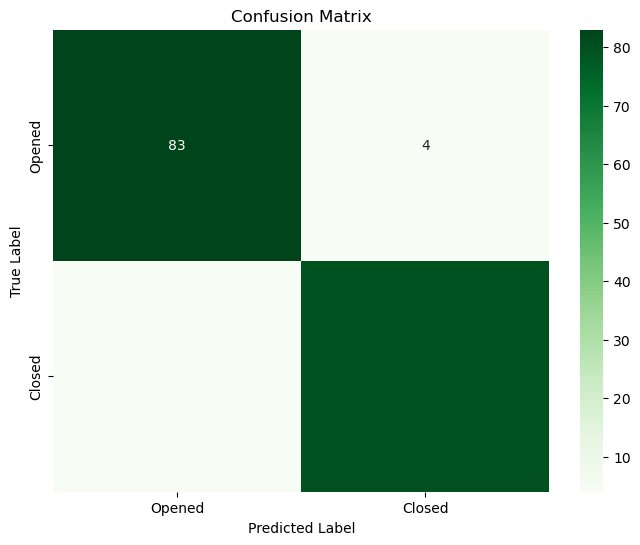

In [35]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model EfficientNetV2S 4**

1/1 [==============================] - 0s 75ms/step


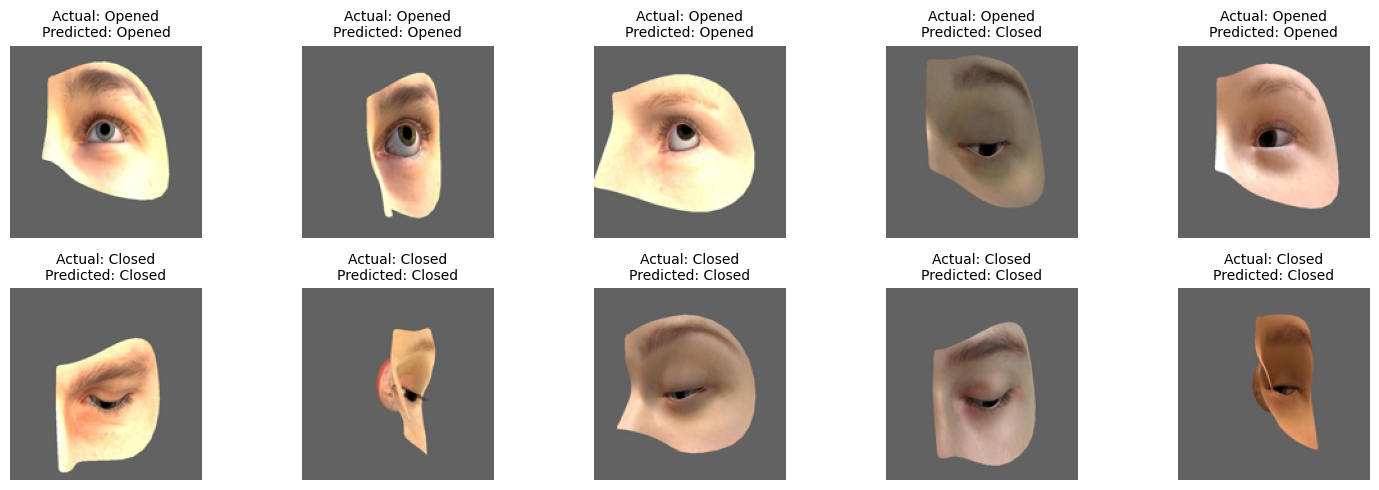

In [36]:
# Load model_predict_4 .h5
model_predict_4 = tf.keras.models.load_model('best_model_v2s_4.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_4.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 5 CNN + EfficientNetV2S [Trainable 30 last layer - Regularization Yes - Batch Size 64]**

Model kelima adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning EfficientNetV2S dengan melakukan tarining 30 layer terakhir V2S, memakai regularization dan batch size = 64

In [37]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Membuka beberapa layer terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Disable semua layer untuk dilatih kecuali 30 layer terakhir
    layer.trainable = False

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_v2s_5
x = base_model(inputs, training=True)  # training=True untuk memastikan fine-tuning
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(0.01)  # Menambahkan weight regularization
)(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_v2s_5
model_v2s_5 = Model(inputs, outputs)

# Compile model_v2s_5
model_v2s_5.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointV2S_5 = ModelCheckpoint(
    'best_model_v2s_5.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_v2s_5 dengan batch size 64
batch_size = 64
historyV2S_5 = model_v2s_5.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointV2S_5, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 7.3463 - accuracy: 0.8787
Epoch 1: val_accuracy improved from -inf to 0.90643, saving model to best_model_v2s_5.h5
24/24 [==============================] - 87s 3s/step - loss: 7.3463 - accuracy: 0.8787 - val_loss: 3.5875 - val_accuracy: 0.9064
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 1.9318 - accuracy: 0.9348
Epoch 2: val_accuracy improved from 0.90643 to 0.92398, saving model to best_model_v2s_5.h5
24/24 [==============================] - 68s 3s/step - loss: 1.9318 - accuracy: 0.9348 - val_loss: 0.8851 - val_accuracy: 0.9240
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.9439
Epoch 3: val_accuracy improved from 0.92398 to 0.94152, saving model to best_model_v2s_5.h5
24/24 [==============================] - 61s 3s/step - loss: 0.5081 - accuracy: 0.9439 - val_loss: 0.3210 - val_accuracy: 0.9415
Epoch 4/30
24/24 [==============================] - ETA: 0

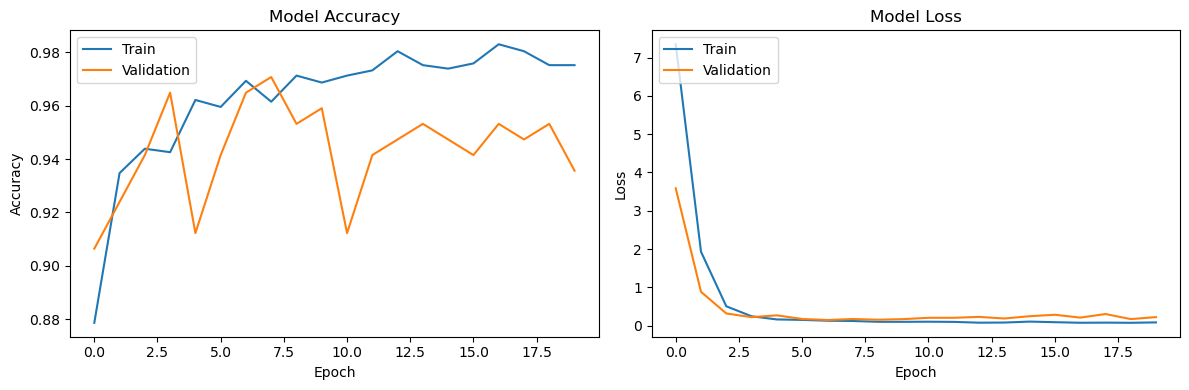

In [38]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S_5.history['accuracy'])
ax1.plot(historyV2S_5.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S_5.history['loss'])
ax2.plot(historyV2S_5.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [39]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_v2s_5.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_v2s_5.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_v2s_5 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + EfficientNetV2S 5:')
print(class_report_v2s_5)

6/6 [==============================] - 6s 922ms/step - loss: 0.1592 - accuracy: 0.9532
validation accuracy: 95.322%
validation loss: 0.1592
6/6 [==============================] - 9s 865ms/step
Classification Report Model CNN + EfficientNetV2S 5:
              precision    recall  f1-score   support

      Opened       0.98      0.93      0.95        87
      Closed       0.93      0.98      0.95        84

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



Confusion Matrix:
[[81  6]
 [ 2 82]]


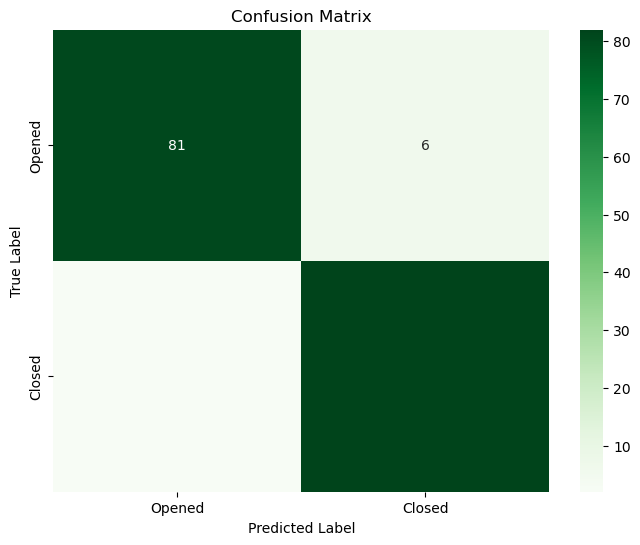

In [40]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model EfficientNetV2S 5**

1/1 [==============================] - 0s 64ms/step


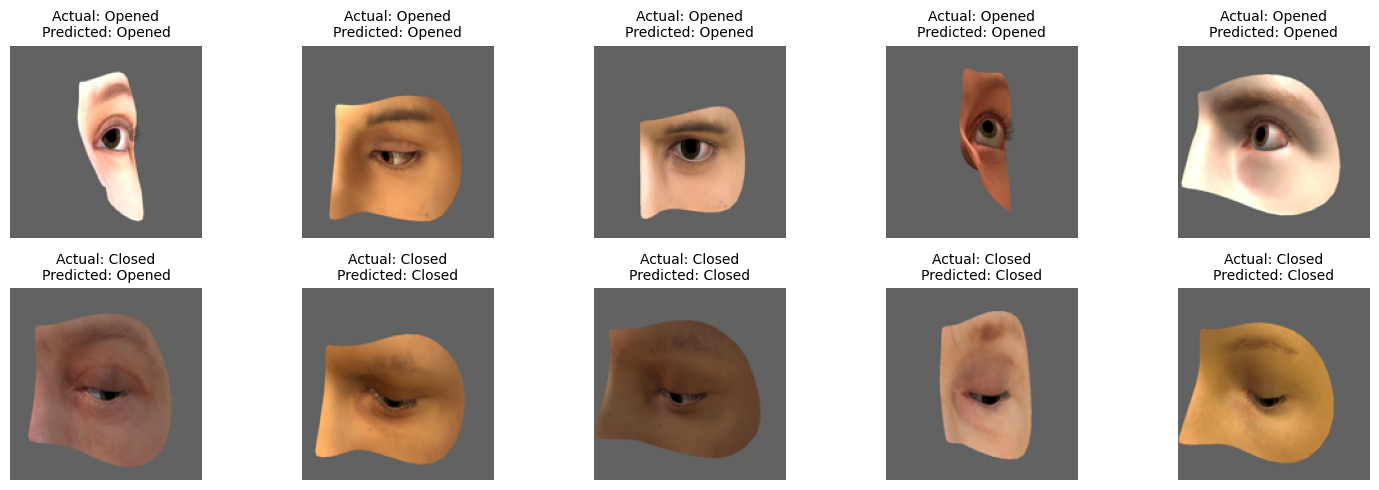

In [41]:
# Load model_predict_5 .h5
model_predict_5 = tf.keras.models.load_model('best_model_v2s_5.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_5.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 6 CNN + EfficientNetV2S [No Trainable 30 last layer - Regularization Yes - Batch Size 64]**

Model keenam adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning EfficientNetV2S tanpa melakukan tarining 30 layer terakhir V2S, memakai regularization dan batch size = 64

In [42]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_v2s_6
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_v2s_6
model_v2s_6 = Model(inputs, outputs)

# Compile model_v2s_6
model_v2s_6.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointV2S_6 = ModelCheckpoint(
    'best_model_v2s_6.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_v2s_6 dengan batch size 64
batch_size = 64
historyV2S_6 = model_v2s_6.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointV2S_6, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 8.1101 - accuracy: 0.7932
Epoch 1: val_accuracy improved from -inf to 0.90058, saving model to best_model_v2s_6.h5
24/24 [==============================] - 67s 2s/step - loss: 8.1101 - accuracy: 0.7932 - val_loss: 4.5990 - val_accuracy: 0.9006
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 2.9519 - accuracy: 0.9145
Epoch 2: val_accuracy improved from 0.90058 to 0.90643, saving model to best_model_v2s_6.h5
24/24 [==============================] - 51s 2s/step - loss: 2.9519 - accuracy: 0.9145 - val_loss: 1.7427 - val_accuracy: 0.9064
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 1.2495 - accuracy: 0.9185
Epoch 3: val_accuracy improved from 0.90643 to 0.92982, saving model to best_model_v2s_6.h5
24/24 [==============================] - 50s 2s/step - loss: 1.2495 - accuracy: 0.9185 - val_loss: 0.8653 - val_accuracy: 0.9298
Epoch 4/30
24/24 [==============================] - ETA: 0

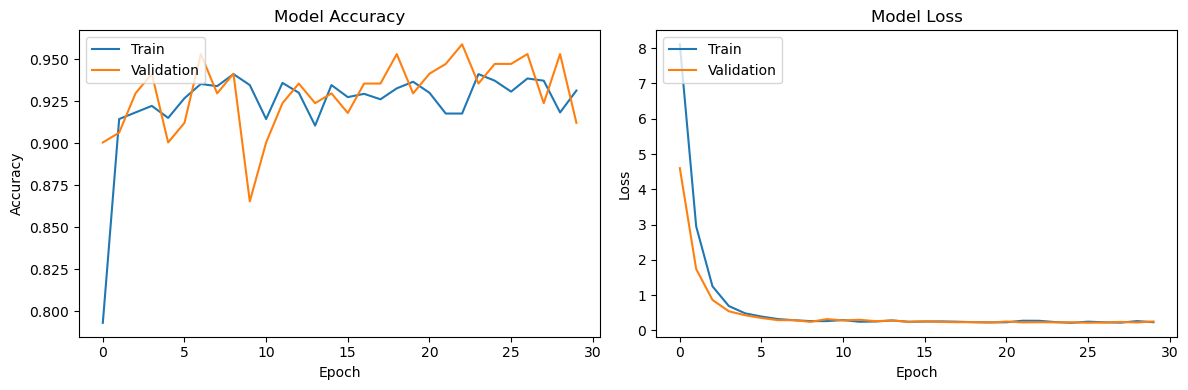

In [43]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S_6.history['accuracy'])
ax1.plot(historyV2S_6.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S_6.history['loss'])
ax2.plot(historyV2S_6.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [44]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_v2s_6.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_v2s_6.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_v2s_6 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + EfficientNetV2S 6:')
print(class_report_v2s_6)

6/6 [==============================] - 8s 2s/step - loss: 0.2551 - accuracy: 0.9123
validation accuracy: 91.228%
validation loss: 0.2551
6/6 [==============================] - 11s 804ms/step
Classification Report Model CNN + EfficientNetV2S 6:
              precision    recall  f1-score   support

      Opened       0.88      0.95      0.92        87
      Closed       0.95      0.87      0.91        84

    accuracy                           0.91       171
   macro avg       0.92      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171



Confusion Matrix:
[[83  4]
 [11 73]]


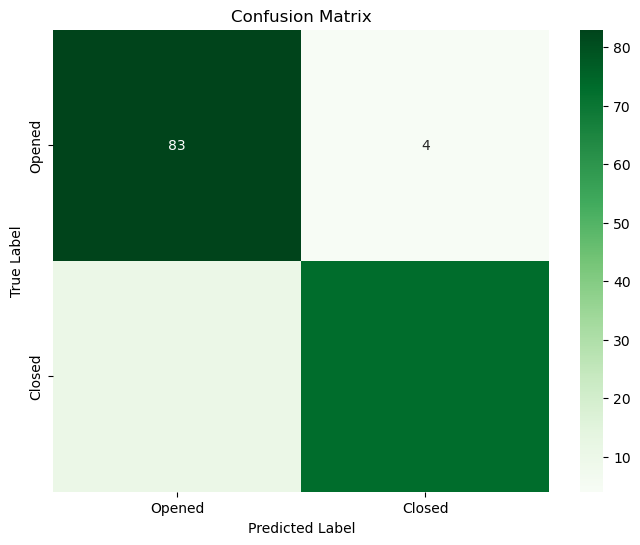

In [45]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model EfficientNetV2S 6**

1/1 [==============================] - 0s 63ms/step


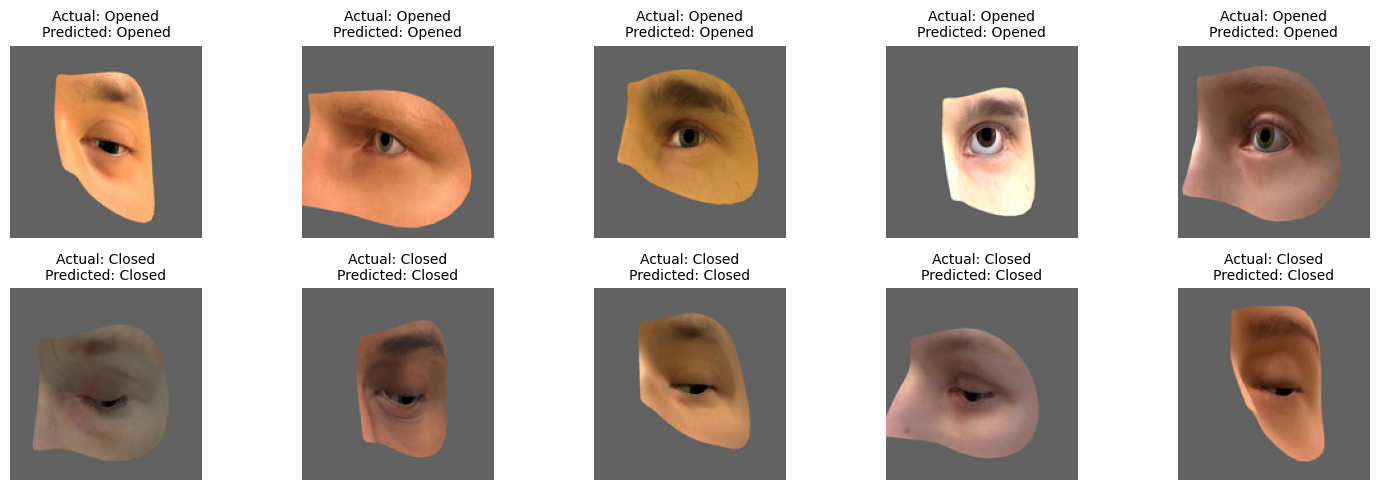

In [46]:
# Load model_predict_6 .h5
model_predict_6 = tf.keras.models.load_model('best_model_v2s_6.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_6.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 7 CNN + EfficientNetV2S [Trainable 30 last layer - Regularization No - Batch Size 64]**

Model ketujuh adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning EfficientNetV2S dengan melakukan tarining 30 layer terakhir V2S, tanpa regularization dan batch size = 64

In [47]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Membuka beberapa layer terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Disable semua layer untuk dilatih kecuali 30 layer terakhir
    layer.trainable = False

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_v2s_7
x = base_model(inputs, training=True)  # training=True untuk memastikan fine-tuning
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_v2s_7
model_v2s_7 = Model(inputs, outputs)

# Compile model_v2s_7
model_v2s_7.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointV2S_7 = ModelCheckpoint(
    'best_model_v2s_7.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_v2s_7 dengan batch size 64
batch_size = 64
historyV2S_7 = model_v2s_7.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointV2S_7, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8741
Epoch 1: val_accuracy improved from -inf to 0.92398, saving model to best_model_v2s_7.h5
24/24 [==============================] - 83s 3s/step - loss: 0.3158 - accuracy: 0.8741 - val_loss: 0.1907 - val_accuracy: 0.9240
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9348
Epoch 2: val_accuracy improved from 0.92398 to 0.94737, saving model to best_model_v2s_7.h5
24/24 [==============================] - 62s 3s/step - loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.1564 - val_accuracy: 0.9474
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9498
Epoch 3: val_accuracy did not improve from 0.94737
24/24 [==============================] - 76s 3s/step - loss: 0.1252 - accuracy: 0.9498 - val_loss: 0.1752 - val_accuracy: 0.9415
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.9524
Epoch

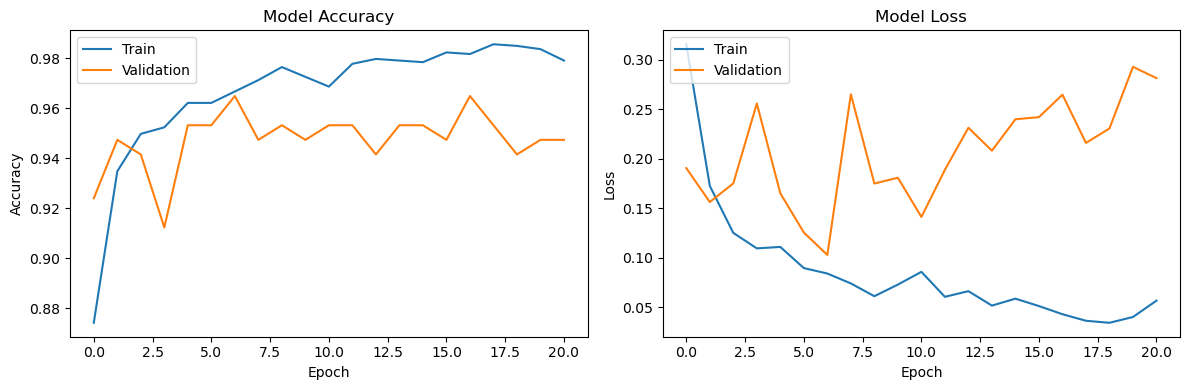

In [48]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S_7.history['accuracy'])
ax1.plot(historyV2S_7.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S_7.history['loss'])
ax2.plot(historyV2S_7.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [49]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_v2s_7.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_v2s_7.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_v2s_7 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + EfficientNetV2S 7:')
print(class_report_v2s_7)

6/6 [==============================] - 8s 1s/step - loss: 0.1149 - accuracy: 0.9532
validation accuracy: 95.322%
validation loss: 0.1149
6/6 [==============================] - 10s 808ms/step
Classification Report Model CNN + EfficientNetV2S 7:
              precision    recall  f1-score   support

      Opened       0.93      0.94      0.94        87
      Closed       0.94      0.93      0.93        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Confusion Matrix:
[[82  5]
 [ 6 78]]


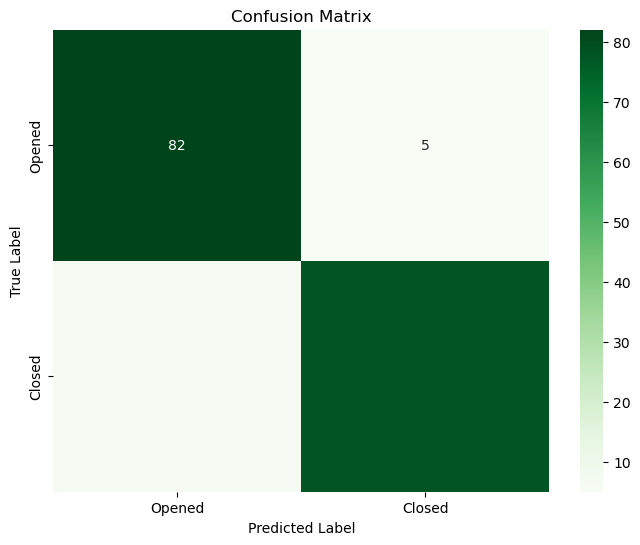

In [50]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model EfficientNetV2S 7**

1/1 [==============================] - 0s 79ms/step


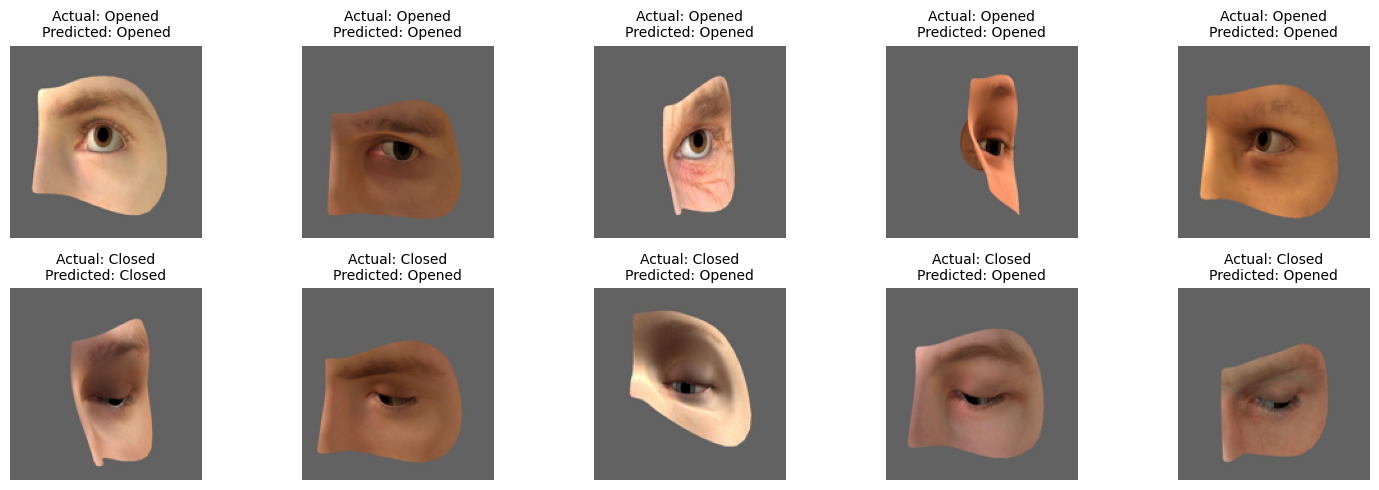

In [51]:
# Load model_predict_7 .h5
model_predict_7 = tf.keras.models.load_model('best_model_v2s_7.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_7.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 8 CNN + EfficientNetV2S [No Trainable 30 last layer - Regularization No - Batch Size 64]**

Model kedepalapn adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning EfficientNetV2S tanpa melakukan tarining 30 layer terakhir V2S, tanpa regularization dan batch size = 64

In [52]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_v2s_8
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_v2s_8
model_v2s_8 = Model(inputs, outputs)

# Compile model_v2s_8
model_v2s_8.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointV2S_8 = ModelCheckpoint(
    'best_model_v2s_8.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_v2s_8 dengan batch size 64
batch_size = 64
historyV2S_8 = model_v2s_8.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointV2S_8, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8441
Epoch 1: val_accuracy improved from -inf to 0.92982, saving model to best_model_v2s_8.h5
24/24 [==============================] - 68s 2s/step - loss: 0.3290 - accuracy: 0.8441 - val_loss: 0.2353 - val_accuracy: 0.9298
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.9295
Epoch 2: val_accuracy did not improve from 0.92982
24/24 [==============================] - 51s 2s/step - loss: 0.1826 - accuracy: 0.9295 - val_loss: 0.1772 - val_accuracy: 0.9298
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9367
Epoch 3: val_accuracy improved from 0.92982 to 0.93567, saving model to best_model_v2s_8.h5
24/24 [==============================] - 51s 2s/step - loss: 0.1565 - accuracy: 0.9367 - val_loss: 0.1704 - val_accuracy: 0.9357
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9354
Epoch

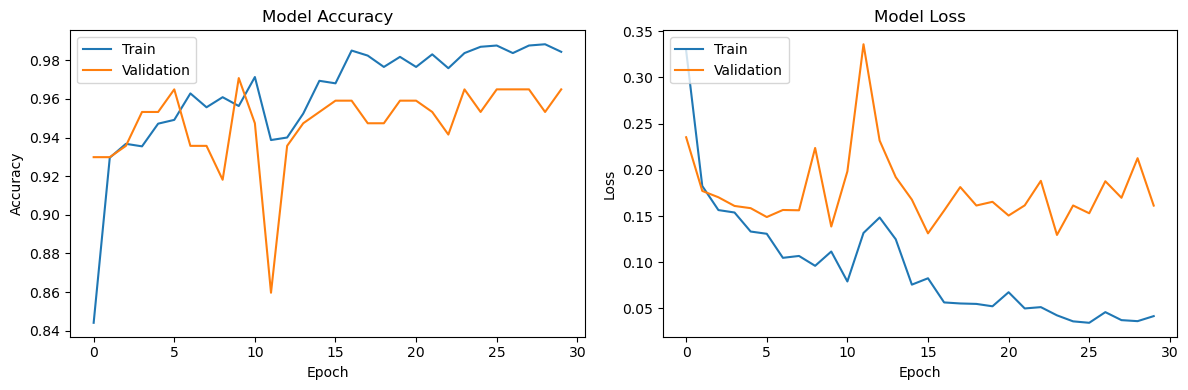

In [53]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S_8.history['accuracy'])
ax1.plot(historyV2S_8.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S_8.history['loss'])
ax2.plot(historyV2S_8.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [54]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_v2s_8.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_v2s_8.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_v2s_8 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + EfficientNetV2S 8:')
print(class_report_v2s_8)

6/6 [==============================] - 5s 787ms/step - loss: 0.1613 - accuracy: 0.9649
validation accuracy: 96.491%
validation loss: 0.1613
6/6 [==============================] - 8s 801ms/step
Classification Report Model CNN + EfficientNetV2S 8:
              precision    recall  f1-score   support

      Opened       0.99      0.94      0.96        87
      Closed       0.94      0.99      0.97        84

    accuracy                           0.96       171
   macro avg       0.97      0.97      0.96       171
weighted avg       0.97      0.96      0.96       171



Confusion Matrix:
[[82  5]
 [ 1 83]]


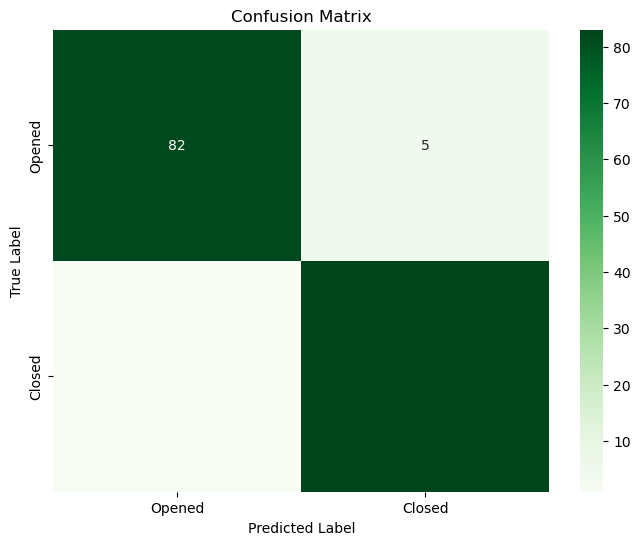

In [55]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model EfficientNetV2S 8**

1/1 [==============================] - 0s 79ms/step


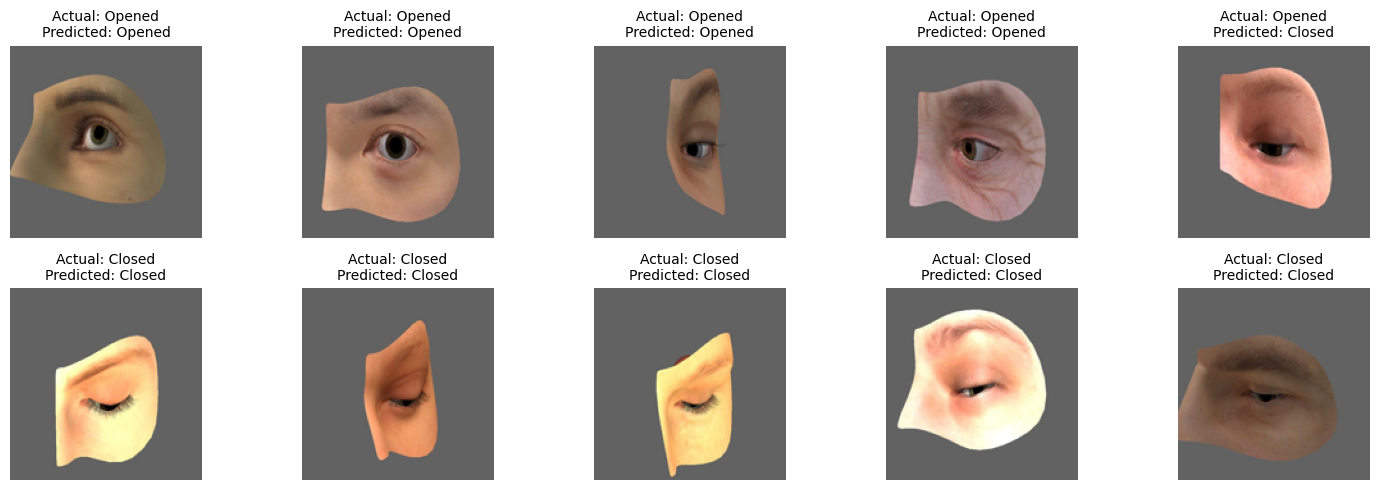

In [56]:
# Load model_predict_8 .h5
model_predict_8 = tf.keras.models.load_model('best_model_v2s_8.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_8.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model Evaluation**

In [57]:
import time

# List model file paths
model_paths = [
    'best_model_v2s_1.h5',
    'best_model_v2s_2.h5',
    'best_model_v2s_3.h5',
    'best_model_v2s_4.h5',
    'best_model_v2s_5.h5',
    'best_model_v2s_6.h5',
    'best_model_v2s_7.h5',
    'best_model_v2s_8.h5'
]

# Placeholder untuk nama kategori
categories = ['Opened', 'Closed']  # Sesuaikan dengan kategori Anda

# Loop untuk mengevaluasi setiap model
for model_path in model_paths:
    print(f"\n# Evaluasi model: {model_path}")
    
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Start timer untuk runtime
    start_time = time.time()
    
    # Evaluasi model pada validation set
    validation_loss, validation_accuracy = model.evaluate(x_validation, y_validation, verbose=1)
    
    # Prediksi untuk classification report
    y_pred = model.predict(x_validation, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_validation, axis=1)
    
    # Hitung runtime
    runtime = time.time() - start_time
    
    # Classification report
    class_report = classification_report(y_true, y_pred_classes, target_names=categories)

    # confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
    # Tampilkan hasil evaluasi
    print(f"\nRuntime: {runtime:.1f} s")
    print(f"Validation Accuracy: {validation_accuracy * 100:.3f}%")
    print(f"Validation Loss: {validation_loss:.4f}")
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)



# Evaluasi model: best_model_v2s_1.h5
6/6 [==============================] - 9s 814ms/step

Runtime: 17.6 s
Validation Accuracy: 95.906%
Validation Loss: 0.1698
Classification Report:
              precision    recall  f1-score   support

      Opened       0.96      0.92      0.94        87
      Closed       0.92      0.96      0.94        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Confusion Matrix:
[[80  7]
 [ 3 81]]

# Evaluasi model: best_model_v2s_2.h5
6/6 [==============================] - 7s 786ms/step

Runtime: 15.4 s
Validation Accuracy: 95.906%
Validation Loss: 0.2343
Classification Report:
              precision    recall  f1-score   support

      Opened       0.99      0.93      0.96        87
      Closed       0.93      0.99      0.96        84

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96     

## **Kesimpulan**

Pada project Computer Vision ini menggunakan algoritma Convolutional Neural Network yang disuntikan model transfer learning EfficientNetV2S dengan membandingkan jika sebuah Model CNN dilakukan trainable pada beberapa layer transfer learning, diberi atau tidak diberikan parameter regularizer dan perbedaan batch size. Kedelapan model CNN ini dapat dibandingkan untuk melihat model mana yang menghasilkan akurasi paling baik, runtime terendah, dan loss terendah. Berikut adalah hasil perbadingan akurasi dari keempat model:

1. Model CNN EfficientNetV2S 1 dengan Trainable layer, dengan Regularizers, dan batch Size 32 ====> `Loss: 0.1698 ; Validation Acc: 95.9% ; F1-Score: 94% (17.6 s)`
2. Model CNN EfficientNetV2S 2 tanpa Trainable layer, dengan Regularizers dan batch Size 32 =====> `Loss: 0.2343 ; Validation Acc: 95.9% ; F1-Score: 96% (15.4 s)`
3. Model CNN EfficientNetV2S 3 dengan Trainable layer, tanpa Regularizers, dan batch Size 32 ====> `Loss: 0.1406 ; Validation Acc: 94.7% ; F1-Score: 95% (17.0 s`)
4. Model CNN EfficientNetV2S 4 tanpa Trainable layer, tanpa Regularizers, dan batch Size 32 ===> `Loss: 0.1571 ; Validation Acc: 96.5% ; F1-Score: 96% (15.6 s)`
5. Model CNN EfficientNetV2S 5 dengan Trainable layer, dengan Regularizers, dan batch Size 64 ====> `Loss: 0.2043 ; Validation Acc: 97.0% ; F1-Score: 96% (17.4 s)`
6. Model CNN EfficientNetV2S 6 tanpa Trainable layer, dengan Regularizers, dan batch Size 64 =====> `Loss: 0.2334 ; Validation Acc: 95.9% ; F1-Score: 96% (15.1 s)`
7. Model CNN EfficientNetV2S 7 dengan Trainable layer, tanpa Regularizers, dan batch Size 64 ====> `Loss: 0.1338 ; Validation Acc: 95.3% ; F1-Score: 96% (17.0 s`)
8. **Model CNN EfficientNetV2S 8 tanpa Trainable layer, tanpa Regularizers, dan batch Size 64 ===> `Loss: 0.1387 ; Validation Acc: 97.0% ; F1-Score: 97% (15.6 s)`**

Seluruh model tidak memiliki overvitting maupun underfitting yang ditunjukan dari plot visualisasi loss dan akurasi data training dan validation. Oleh karena itu Model **CNN EfficientNetV2S 8 tanpa Trainable layer, tanpa Regularizers, dan batch Size 64** menjadi model paling baik untuk dataset model kantuk ini.

Untuk pemodelan lebih lanjut, data pada folder TrainingSet dapat ditambahkan data dari ImprovementSet untuk memperbanyak data dan bisa menambah akurasi yang dihasilkan nantinya.

## **Arsitektur Model**

In [5]:
arch = tf.keras.models.load_model('best_model_v2s_4.h5')
arch.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 5, 5, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 2)                 2050

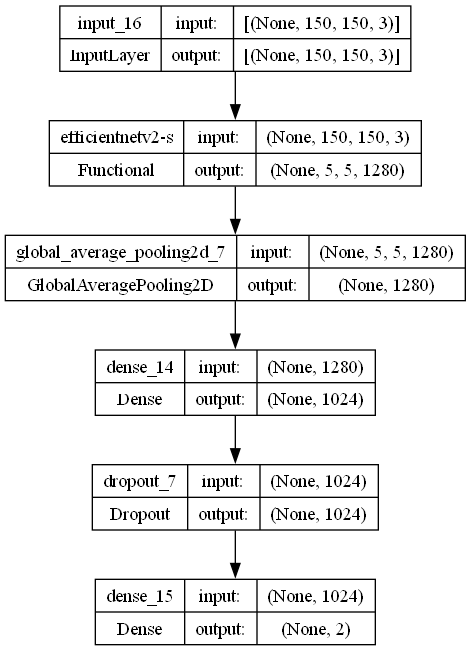

In [3]:
import pydot
from tensorflow.keras.utils import plot_model

# Plot arsitektur model
plot_model(arch, to_file='model_architecture_efficientnetv2s.png', show_shapes=True, show_layer_names=True)